# Coregionalized Gaussian Process Regression

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import pymc3 as pm
import arviz as az
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise as pw
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.moment_helpers import cov2corr
from pathlib import Path  

In [37]:
%cd "C:\\Users\\Jared\\Desktop\\Lead Hazard"

C:\Users\Jared\Desktop\Lead Hazard


## Preprocessing

In [38]:
data = pd.read_csv('Soil Data.csv')
data['XRF (ppm)'] = data['XRF (ppm)'].replace(['LOD'], 15)
data_essential = data.drop(['Depth','Sampled','Analyzed'], axis = 1)
data_no_missing = data_essential.dropna()
data_numbers = data_no_missing.astype('float')

In [39]:
data_numbers.head()

,ID,Soil (ppm),XRF (ppm),X Loc,Y Loc
0,77.0,20.9,15.0,12.0,0.0
1,81.0,1230.0,518.0,12.0,4.0
2,61.0,38.8,15.0,9.0,1.0
3,27.0,237.0,389.0,3.0,-1.0
4,38.0,149.0,60.0,4.0,4.0


In [79]:
data_numbers.shape

(39, 5)

Outlier Removal (Purely for Visualization)

In [40]:
data_one_removed = data_numbers.drop(data_numbers['XRF (ppm)'].idxmax(), axis = 0).reset_index(drop = True)
data_two_removed = data_one_removed.drop(data_one_removed['XRF (ppm)'].idxmax(), axis = 0).reset_index(drop = True)

Numpy Formatting

In [78]:
X = data_numbers.copy()
y = X.pop('Soil (ppm)').values
X = X.values

X_one_removed = data_one_removed.copy()
y_one_removed = X_one_removed.pop('Soil (ppm)').values
X_one_removed = X_one_removed.values

X_two_removed = data_two_removed.copy()
y_two_removed = X_two_removed.pop('Soil (ppm)').values
X_two_removed = X_two_removed.values

x = X[:,[1]]
x_one_removed = X_one_removed[:,[1]]
x_two_removed = X_two_removed[:,[1]]

Log Transformation

In [42]:
log_data = data_numbers.copy()
log_data['XRF (ppm)'] = np.log10(log_data['XRF (ppm)'])
log_data['Soil (ppm)'] = np.log10(log_data['Soil (ppm)'])

log_data_one_removed = data_one_removed.copy()
log_data_one_removed['XRF (ppm)'] = np.log10(log_data_one_removed['XRF (ppm)'])
log_data_one_removed['Soil (ppm)'] = np.log10(log_data_one_removed['Soil (ppm)'])

log_data_two_removed = data_two_removed.copy()
log_data_two_removed['XRF (ppm)'] = np.log10(log_data_two_removed['XRF (ppm)'])
log_data_two_removed['Soil (ppm)'] = np.log10(log_data_two_removed['Soil (ppm)'])

Change variables for log data in preparation for Gaussian process: regress y2 on y1, and X now corresponds to location

In [43]:
log_X = log_data.copy()
log_y1 = log_X.pop('XRF (ppm)').values
log_y2 = log_X.pop('Soil (ppm)').values
log_X = log_X.values

All Datasets

In [44]:
data_sets = [data_numbers, data_one_removed, data_two_removed]
log_data_sets = [log_data, log_data_one_removed, log_data_two_removed]
variables = ['Soil (ppm)', 'XRF (ppm)']

## Exploratory Data Analysis

### Original Data

In [45]:
sns.set_style("white")

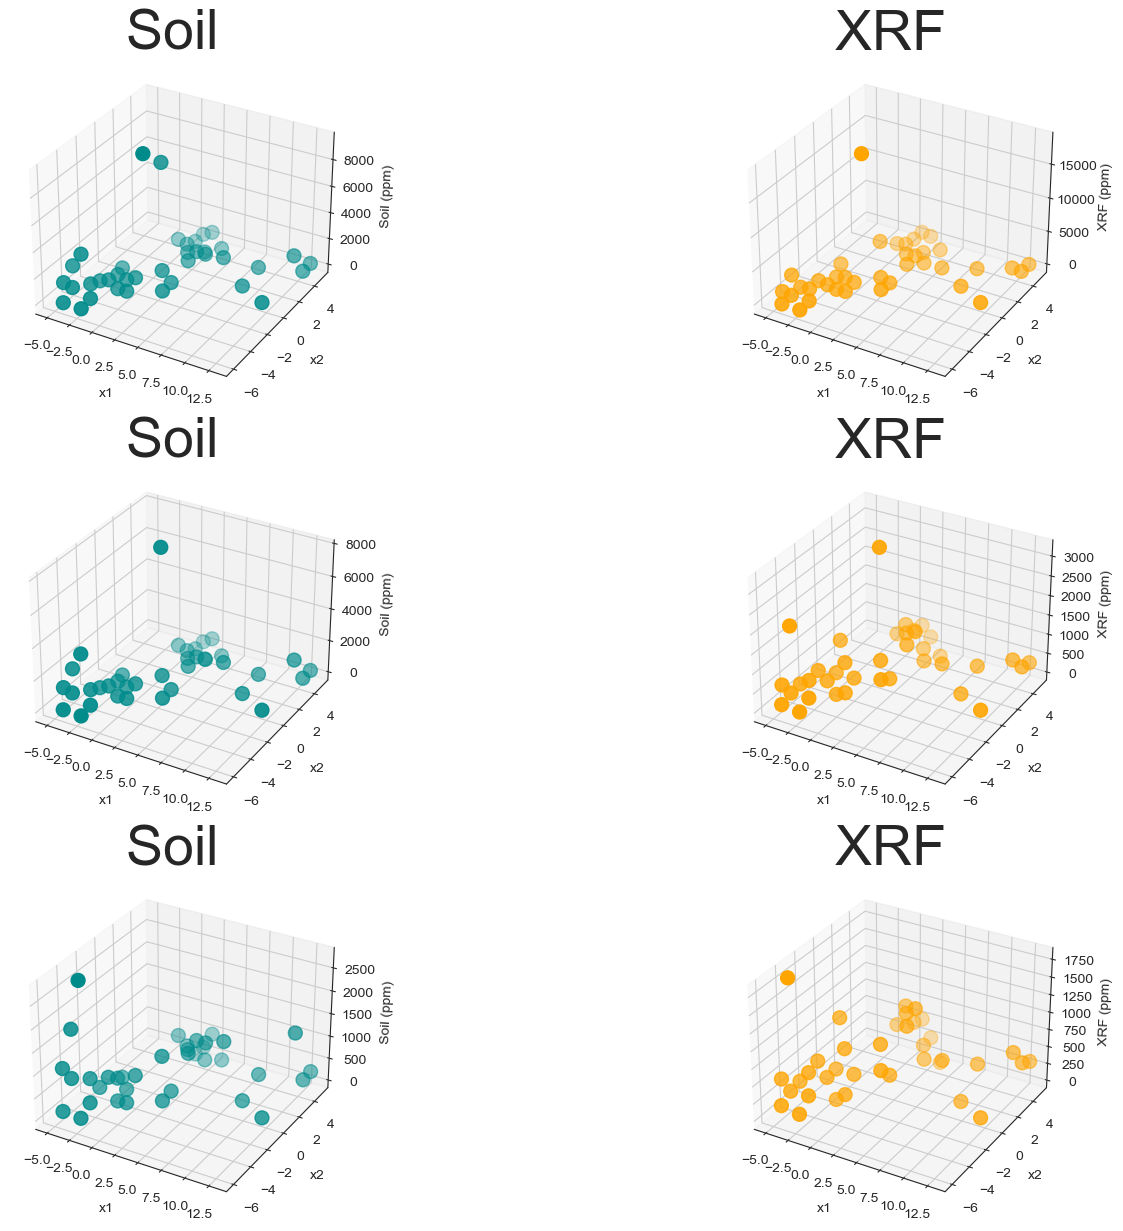

In [46]:
fig = plt.figure(figsize=(17, 15))

i = 1
for data_set in data_sets:
    
    x1 = data_set['X Loc'].values
    x2 = data_set['Y Loc'].values
    
    j = 0
    for var in variables:
        
        height = data_set[var].values
        
        if j == 0:
            color = 'darkcyan'
        else:
            color = 'orange'
            
        ax = fig.add_subplot(3, 2, i+j, projection='3d')
        ax.scatter3D(x1, x2, height, s = 100, c = color)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel(var)
        ax.set_title(re.sub(r'\(\w*\)','',var), fontdict = {'fontsize': 40, 'fontweight' : 20})
        
        j += 1
        
    i += 2

plt.show()

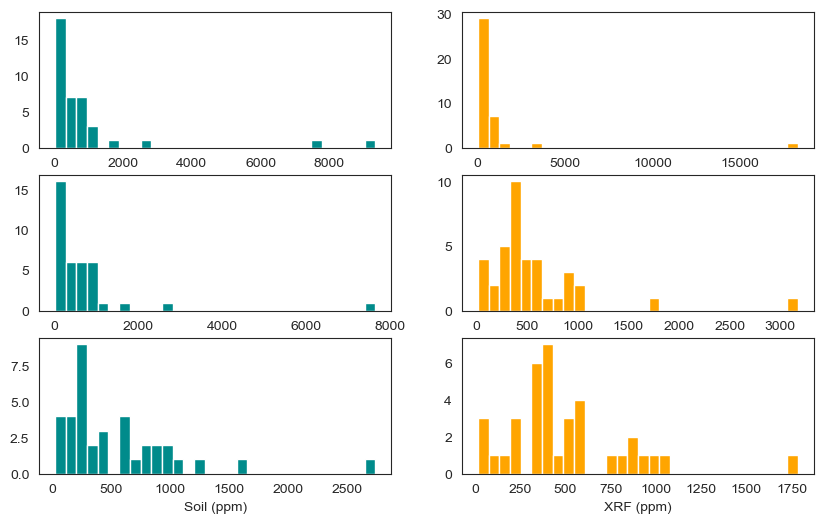

In [47]:
fig = plt.figure(figsize=(10, 6))

i = 1
for data_set in data_sets:
    
    j = 0
    for var in variables:
    
        if j == 0:
            color = 'darkcyan'
        else:
            color = 'orange'
            
        ax = fig.add_subplot(3,2,i+j)
        ax.hist(data = data_set, x = var, bins = 30, color = color)
        ax.set_xlabel(var)

        j += 1
        
    i += 2

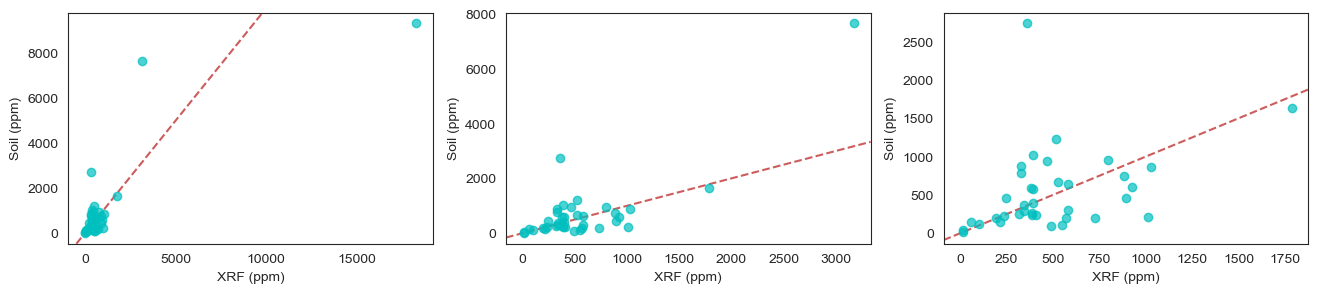

In [48]:
fig = plt.figure(figsize=(16, 3))

i = 1
for data_set in data_sets:
    
    ax = fig.add_subplot(1,3,i)
    ax.axline((0,0), slope = 1, linestyle = '--', color = 'indianred')
    ax.plot(data_set['XRF (ppm)'], data_set['Soil (ppm)'], 'oc', alpha = .7)
    ax.set_xlabel('XRF (ppm)')
    ax.set_ylabel('Soil (ppm)')
    i += 1

plt.show()

### Log Transformed Data

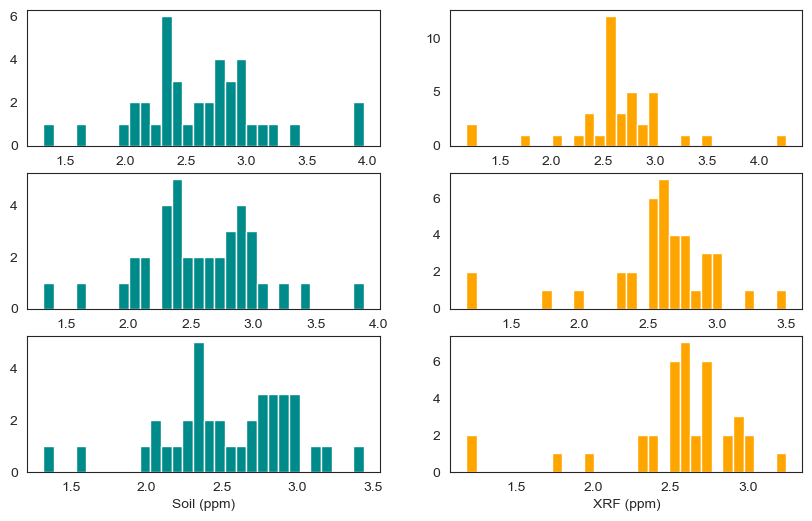

In [49]:
fig = plt.figure(figsize=(10, 6))

i = 1
for log_data_set in log_data_sets:
    
    j = 0
    for var in variables:
    
        if j == 0:
            color = 'darkcyan'
        else:
            color = 'orange'
            
        ax = fig.add_subplot(3,2,i+j)
        ax.hist(data = log_data_set, x = var, bins = 30, color = color)
        ax.set_xlabel(var)

        j += 1
        
    i += 2

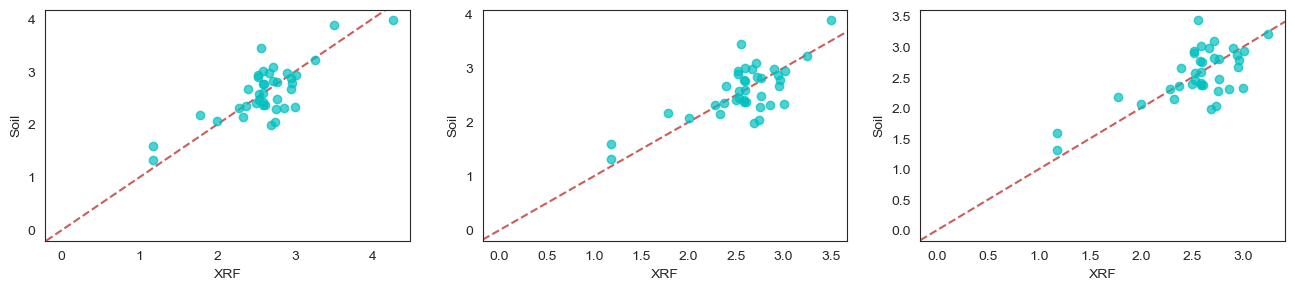

In [50]:
fig = plt.figure(figsize=(16, 3))

i = 1
for log_data_set in log_data_sets:
    
    ax = fig.add_subplot(1,3,i)
    ax.axline((0,0), slope = 1, linestyle = '--', color = 'indianred')
    ax.plot(log_data_set['XRF (ppm)'], log_data_set['Soil (ppm)'], 'oc', alpha = .7)
    ax.set_xlabel('XRF')
    ax.set_ylabel('Soil')

    i += 1

plt.show()

## Basic Linear Modeling

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

### Original Data

In [52]:
slr = LinearRegression(fit_intercept=True)
slr.fit(x,y)
yhat = slr.predict(x)
e = y - yhat

slr1 = LinearRegression(fit_intercept=True)
slr1.fit(x_one_removed, y_one_removed)
yhat1 = slr1.predict(x_one_removed)
e1 = y_one_removed - yhat1

slr2 = LinearRegression(fit_intercept=False)
slr2.fit(x_two_removed, y_two_removed)
yhat2 = slr2.predict(x_two_removed)
e2 = y_two_removed - yhat2

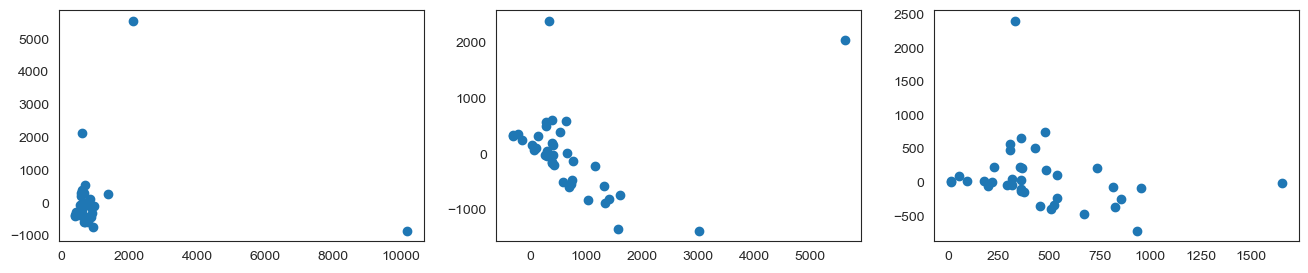

In [53]:
fig = plt.figure(figsize=(16, 3))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.plot(yhat , e, 'o')
ax2.plot(yhat1 , e1, 'o')
ax3.plot(yhat2, e2, 'o')

plt.show()

In [54]:
#import statsmodels.api as sm
import pylab
import scipy.stats as stats

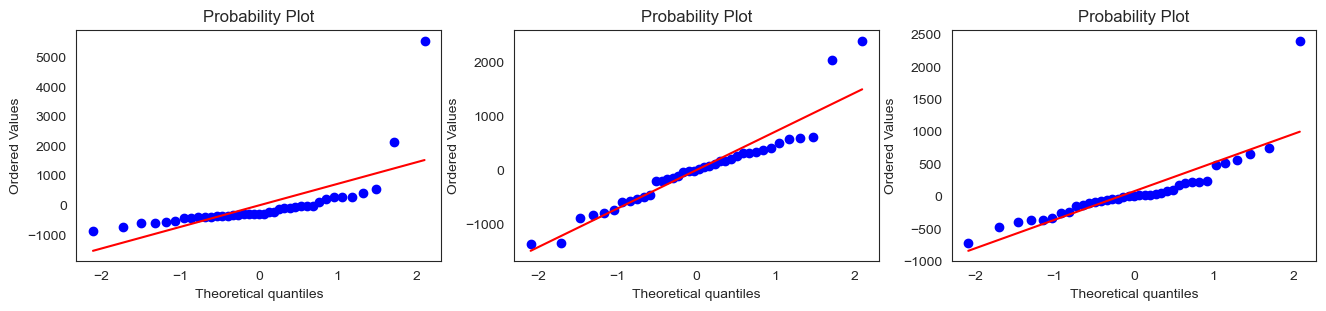

In [55]:
fig = plt.figure(figsize=(16, 3))
ax1 = plt.subplot(131)
res = stats.probplot(e, dist="norm", plot=plt)
ax2 = plt.subplot(132)
res = stats.probplot(e1, dist="norm", plot=plt)
ax3 = plt.subplot(133)
res = stats.probplot(e2, dist="norm", plot=plt)

plt.show()

### Analysis on Original Data

In [56]:
xpred = np.arange(0,2000,20)
yhat_range = slr2.predict(xpred.reshape(-1,1))
#yhat_sqrt_range = slr_sqrt.predict(xpred.reshape(-1,1))

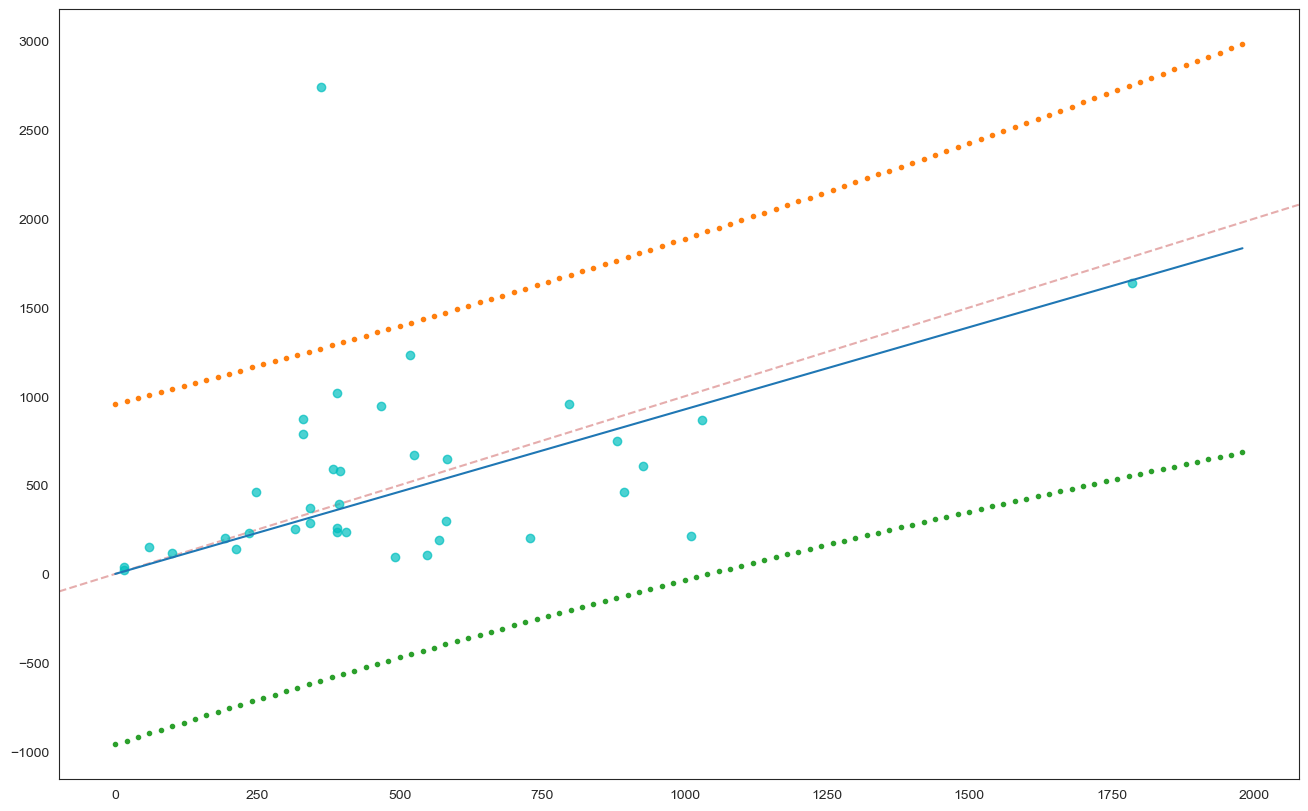

In [57]:
c = 7
n = data_two_removed.shape[0] + c
xbar = x_two_removed.mean()
sxx = ((x_two_removed - xbar)**2).sum()
sigmasqr = (e2**2).sum()/(n-2)
sigma = sigmasqr**(1/2)

predvar = sigmasqr*(1 + 1/n + (xpred - xbar)**2/sxx)
predsd = predvar**(1/2)

upperbound = yhat_range + 1.96*predsd
lowerbound = yhat_range - 1.96*predsd

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(1,1,1)

ax1.axline((0,0), slope = 1, linestyle = '--', color = 'indianred', alpha = .5)
ax1.plot(x_two_removed, y_two_removed, 'oc', alpha = .7)
ax1.plot(xpred, yhat_range, '-')
ax1.plot(xpred, upperbound, ".")
ax1.plot(xpred, lowerbound, ".")


plt.show()

### Log Transformed Data

In [58]:
log_y1_ = log_y1.reshape(-1,1)
log_y2_ = log_y2.reshape(-1,1)

In [59]:
log_slr = LinearRegression(fit_intercept=True)
log_slr.fit(log_y1_, log_y2_)
log_yhat = log_slr.predict(log_y1_)
log_e = log_y2_ - log_yhat

In [60]:
log_slr.coef_

array([[0.78445462]])

In [61]:
log_slr.intercept_

array([0.5595963])

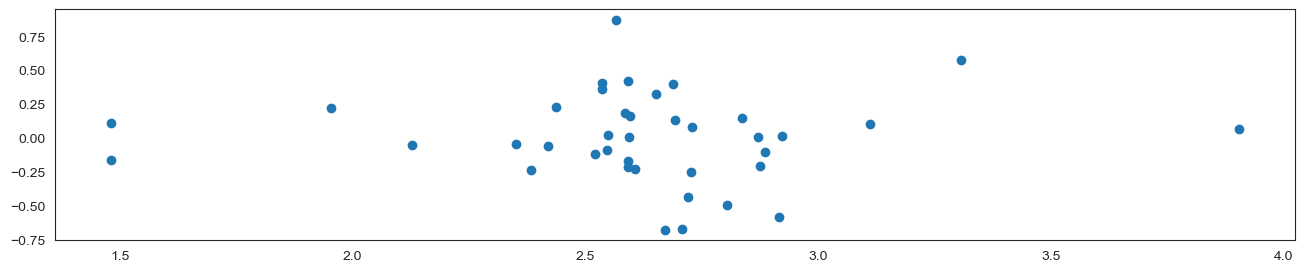

In [62]:
fig = plt.figure(figsize=(16, 3))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(log_yhat, log_e, 'o')

plt.show()

### Analysis on Log Transformed Data

In [63]:
log_y1_pred = np.arange(0,4.5,.05)
log_y2_hat_range = log_slr.predict(log_y1_pred.reshape(-1,1))

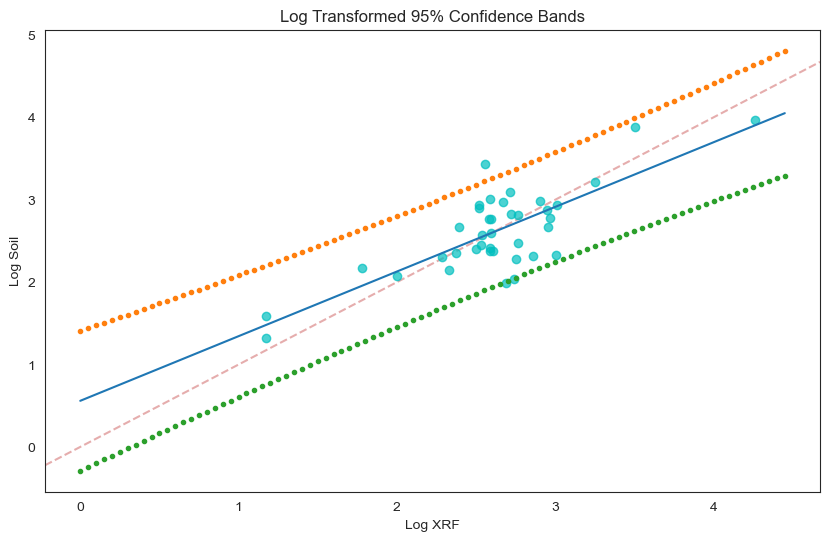

In [81]:
# prediction bands

c = 0
log_n = log_data.shape[0] + c
log_y1_bar = log_y1_.mean()
log_sxx = ((log_y1_ - log_y1_bar)**2).sum()
log_sigmasqr = (log_e**2).sum()/(log_n-2)
log_sigma = log_sigmasqr**(1/2)

log_predvar = log_sigmasqr*(1 + 1/log_n + (log_y1_pred.reshape(-1,1) - log_y1_bar)**2/log_sxx)
log_predsd = log_predvar**(1/2)

log_upperbound = log_y2_hat_range + 1.96*log_predsd
log_lowerbound = log_y2_hat_range - 1.96*log_predsd

# visual

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1,1,1)

ax1.axline((0,0), slope = 1, linestyle = '--', color = 'indianred', alpha = .5)
ax1.plot(log_y1_, log_y2_, 'oc', alpha = .7)
ax1.plot(log_y1_pred, log_y2_hat_range, '-')
ax1.plot(log_y1_pred, log_upperbound, ".")
ax1.plot(log_y1_pred, log_lowerbound, ".")
#ax1.axline((0,0), slope = 1)
ax1.set_title('Log Transformed 95% Confidence Bands')
ax1.set_xlabel('Log XRF')
ax1.set_ylabel('Log Soil')

plt.show()

### Exponentiating to Original Space

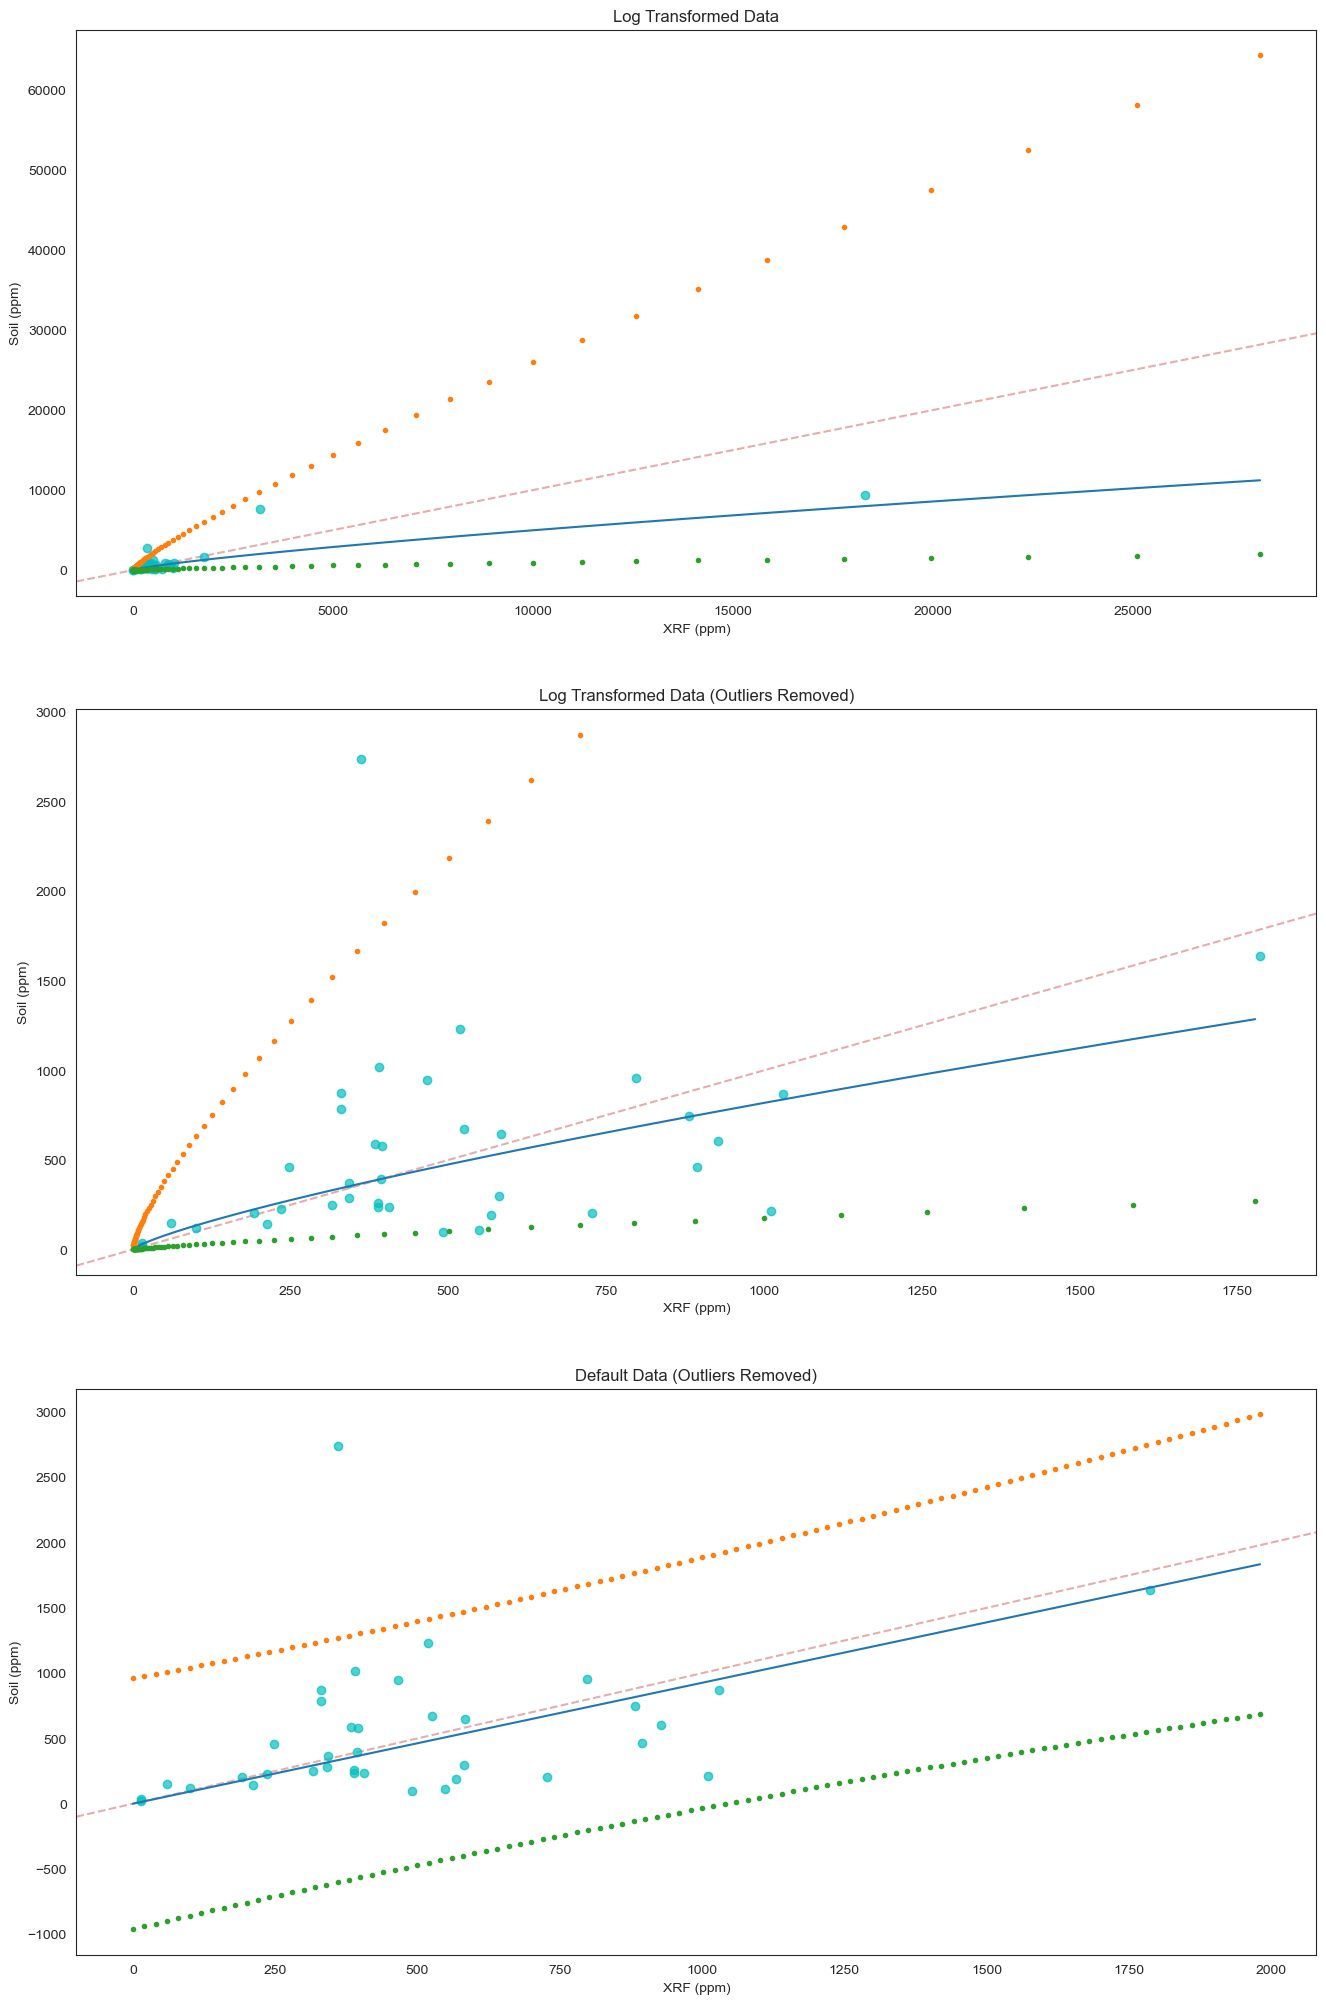

In [66]:
fig = plt.figure(figsize=(16, 25))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.axline((0,0), slope = 1, linestyle = '--', color = 'indianred', alpha = .5)
ax1.plot(x[:,0], y, 'oc', alpha = .7)
ax1.plot(10**log_y1_pred, 10**log_y2_hat_range, '-')
ax1.plot(10**log_y1_pred, 10**log_upperbound, ".")
ax1.plot(10**log_y1_pred, 10**log_lowerbound, ".")
ax1.set_xlabel('XRF (ppm)')
ax1.set_ylabel('Soil (ppm)')
ax1.set_title('Log Transformed Data')

ax2.axline((0,0), slope = 1, linestyle = '--', color = 'indianred', alpha = .5)
ax2.plot(x_two_removed, y_two_removed, 'oc', alpha = .7)
ax2.plot(10**log_y1_pred[:66], 10**log_y2_hat_range[:66], '-')
ax2.plot(10**log_y1_pred[:58], 10**log_upperbound[:58], ".")
ax2.plot(10**log_y1_pred[:66], 10**log_lowerbound[:66], ".")
ax2.set_xlabel('XRF (ppm)')
ax2.set_ylabel('Soil (ppm)')
ax2.set_title('Log Transformed Data (Outliers Removed)')

ax3.axline((0,0), slope = 1, linestyle = '--', color = 'indianred', alpha = .5)
ax3.plot(x_two_removed, y_two_removed, 'oc', alpha = .7)
ax3.plot(xpred, yhat_range, '-')
ax3.plot(xpred, upperbound, ".")
ax3.plot(xpred, lowerbound, ".")
ax3.set_xlabel('XRF (ppm)')
ax3.set_ylabel('Soil (ppm)')
ax3.set_title('Default Data (Outliers Removed)')

plt.show()

## Export

In [67]:
filepath = Path('Log Transformed Data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
log_data.to_csv(filepath)